In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using MeshCat
const mc = MeshCat
using StaticArrays
using Printf

  Activating project at `~/OCRL/HW4_S25`


## Julia note:

incorrect:


`x_l[idx.x[i]][2] = 0 # this does not change x_l`


correct:


`x_l[idx.x[i][2]] = 0 # this changes x_l`


It should always be `v[index] = new_val` if I want to update v with `new_val` at `index`.

In [2]:
let 
    
    # vector we want to modify 
    Z = randn(5)
    
    # original value of Z so we can check if we are changing it
    Z_original = 1 * Z 
    
    # index range we are considering
    idx_x = 1:3 
    
    # this does NOT change Z 
    Z[idx_x][2] = 0 
    
    # we can prove this 
    @show norm(Z - Z_original) 
    
    # this DOES change Z 
    Z[idx_x[2]] = 0 
    
    # we can prove this 
    @show norm(Z - Z_original) 
    
    
end

norm(Z - Z_original) = 0.0
norm(Z - Z_original) = 0.06190702491114991


0.06190702491114991

In [3]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","walker.jl"))

update_walker_pose! (generic function with 1 method)

![](walker.gif)
(If nothing loads here, check out `walker.gif` in the repo)

**NOTE: This question will have long outputs for each cell, remember you can use `cell -> all output -> toggle scrolling` to better see it all**

# Q2: Hybrid Trajectory Optimization  (60 pts)
In this problem you'll use a direct method to optimize a walking trajectory for a simple biped model, using the hybrid dynamics formulation. You'll pre-specify a gait sequence and solve the problem using Ipopt. Your final solution should look like the video above.

## The Dynamics
Our system is modeled as three point masses: one for the body and one for each foot. The state is defined as the x and y positions and velocities of these masses, for a total of 6 degrees of freedom and 12 states. We will label the position and velocity of each body with the following notation:
$$ \begin{align} 
r^{(b)} &= \begin{bmatrix} p_x^{(b)} \\ p_y^{(b)} \end{bmatrix} & v^{(b)} &= \begin{bmatrix} v_x^{(b)} \\ v_y^{(b)} \end{bmatrix}\\
r^{(1)} &= \begin{bmatrix} p_x^{(1)} \\ p_y^{(1)} \end{bmatrix} & v^{(1)} &= \begin{bmatrix} v_x^{(1)}\\
v_y^{(1)} \end{bmatrix}\\
r^{(2)} &= \begin{bmatrix} p_x^{(2)} \\ p_y^{(2)} \end{bmatrix} & v^{(2)} &= \begin{bmatrix} v_x^{(2)}\\
v_y^{(2)} \end{bmatrix}
\end{align}$$
Each leg is connected to the body with prismatic joints. The system has three control inputs: a force along each leg, and the torque between the legs.

The state and control vectors are ordered as follows:

$$ x = \begin{bmatrix} 
    p_x^{(b)} \\ p_y^{(b)} \\ p_x^{(1)} \\ p_y^{(1)} \\ p_x^{(2)} \\ p_y^{(2)} \\
    v_x^{(b)} \\ v_y^{(b)} \\ v_x^{(1)} \\ v_y^{(1)} \\ v_x^{(2)} \\ v_y^{(2)} \\
\end{bmatrix} \quad
u = \begin{bmatrix} F^{(1)} \\ F^{(2)} \\ \tau \end{bmatrix}
$$
where e.g. $p_x^{(b)}$ is the $x$ position of the body, $v_y^{(i)}$ is the $y$ velocity of foot $i$, $F^{(i)}$ is the force along leg $i$, and $\tau$ is the torque between the legs. 

The continuous time dynamics and jump maps for the two stances are shown below:

In [4]:
function stance1_dynamics(model::NamedTuple, x::Vector, u::Vector)
    # dynamics when foot 1 is in contact with the ground 
    
    mb,mf = model.mb, model.mf
    g = model.g

    M = Diagonal([mb mb mf mf mf mf])
    
    rb  = x[1:2]   # position of the body
    rf1 = x[3:4]   # position of foot 1
    rf2 = x[5:6]   # position of foot 2
    v   = x[7:12]  # velocities
    
    
    ℓ1x = (rb[1]-rf1[1])/norm(rb-rf1)
    ℓ1y = (rb[2]-rf1[2])/norm(rb-rf1)
    ℓ2x = (rb[1]-rf2[1])/norm(rb-rf2)
    ℓ2y = (rb[2]-rf2[2])/norm(rb-rf2)
    
    B = [ℓ1x  ℓ2x  ℓ1y-ℓ2y;
         ℓ1y  ℓ2y  ℓ2x-ℓ1x;
          0    0     0;
          0    0     0;
          0  -ℓ2x  ℓ2y;
          0  -ℓ2y -ℓ2x]
    
    v̇ = [0; -g; 0; 0; 0; -g] + M\(B*u)
    
    ẋ = [v; v̇]
    
    return ẋ
end

function stance2_dynamics(model::NamedTuple, x::Vector, u::Vector)
    # dynamics when foot 2 is in contact with the ground 
    
    mb,mf = model.mb, model.mf
    g = model.g
    M = Diagonal([mb mb mf mf mf mf])
    
    rb  = x[1:2]   # position of the body
    rf1 = x[3:4]   # position of foot 1
    rf2 = x[5:6]   # position of foot 2
    v   = x[7:12]  # velocities
    
    ℓ1x = (rb[1]-rf1[1])/norm(rb-rf1)
    ℓ1y = (rb[2]-rf1[2])/norm(rb-rf1)
    ℓ2x = (rb[1]-rf2[1])/norm(rb-rf2)
    ℓ2y = (rb[2]-rf2[2])/norm(rb-rf2)
    
    B = [ℓ1x  ℓ2x  ℓ1y-ℓ2y;
         ℓ1y  ℓ2y  ℓ2x-ℓ1x;
        -ℓ1x   0  -ℓ1y;
        -ℓ1y   0   ℓ1x;
          0    0    0;
          0    0    0]
    
    v̇ = [0; -g; 0; -g; 0; 0] + M\(B*u)
    
    ẋ = [v; v̇]
    
    return ẋ
end

function jump1_map(x)
    # foot 1 experiences inelastic collision
    xn = [x[1:8]; 0.0; 0.0; x[11:12]]
    return xn
end

function jump2_map(x)
    # foot 2 experiences inelastic collision
    xn = [x[1:10]; 0.0; 0.0]
    return xn
end

function rk4(model::NamedTuple, ode::Function, x::Vector, u::Vector, dt::Real)::Vector
    k1 = dt * ode(model, x,        u)
    k2 = dt * ode(model, x + k1/2, u)
    k3 = dt * ode(model, x + k2/2, u)
    k4 = dt * ode(model, x + k3,   u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end  

rk4 (generic function with 1 method)

We are setting up this problem by scheduling out the contact sequence. To do this, we will define the following sets:

$$ \begin{align} 
\mathcal{M}_1 &= \{1\text{:}5,11\text{:}15,21\text{:}25,31\text{:}35,41\text{:}45\} \\
\mathcal{M}_2 &= \{6\text{:}10,16\text{:}20,26\text{:}30,36\text{:}40\}
\end{align}$$

where $\mathcal{M}_1$ contains the time steps when foot 1 is pinned to the ground (`stance1_dynamics`), and $\mathcal{M}_2$ contains the time steps when foot 2 is pinned to the ground (`stance2_dynamics`). The jump map sets $\mathcal{J}_1$ and $\mathcal{J}_2$ are the indices where the mode of the next time step is different than the current, i.e. $\mathcal{J}_i \equiv \{k+1 \notin \mathcal{M}_i \; | \; k \in \mathcal{M}_i\}$. We can write these out explicitly as the following:

$$ \begin{align} 
\mathcal{J}_1 &= \{5,15,25,35\} \\
\mathcal{J}_2 &= \{10,20,30,40\}
\end{align}$$

Another term you will see is set subtraction, or $\mathcal{M}_i \setminus \mathcal{J}_i$. This just means that if  $k \in \mathcal{M}_i \setminus \mathcal{J}_i$, then $k$ is in $\mathcal{M}_i$ but not in $\mathcal{J}_i$. 

We will make use of the following Julia code for determining which set an index belongs to:

In [5]:
let 
    M1 = vcat([ (i-1)*10      .+ (1:5)   for i = 1:5]...) # stack the set into a vector
    M2 = vcat([((i-1)*10 + 5) .+ (1:5)   for i = 1:4]...) # stack the set into a vector
    J1 = [5,15,25,35]
    J2 = [10,20,30,40]
    
    @show  (5 in M1) # show if 5 is in M1 
    @show  (5 in J1) # show if 5 is in J1 
    @show !(5 in M1) # show is 5 is not in M1 
    
    @show (5 in M1) && !(5 in J1) # 5 in M1 but not J1 (5 ∈ M_1 \ J1)
    
end

5 in M1 = true
5 in J1 = true
!(5 in M1) = false
5 in M1 && !(5 in J1) = false


false

We are now going to setup and solve a constrained nonlinear program.  The optimization problem looks complicated but each piece should make sense and be relatively straightforward to implement. First we have the following LQR cost function that will track $x_{ref}$ (`Xref`) and $u_{ref}$ (`Uref`):

$$  J(x_{1:N},u_{1:N-1}) = \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} (x_i - x_{ref,i})^TQ(x_i - x_{ref,i}) + \frac{1}{2} (u_i-u_{ref,i})^TR(u_i-u_{ref,i}) \bigg] + \frac{1}{2}(x_N - x_{ref,N})^TQ_f(x_N - x_{ref,N})$$

Which goes into the following full optimization problem:
   $$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & J(x_{1:N},u_{1:N-1}) & \\ 
 \text{st} \quad &  x_1 = x_{ic} & \tag{1}\\
 \quad & x_N = x_{g} &\tag{2}\\
 &  x_{k+1} = f_1(x_k,u_k)  &\text{for } k \in  \mathcal{M}_1 \setminus \mathcal{J}_1 \tag{3}\\ 
 &  x_{k+1} = f_2(x_k,u_k)  &\text{for } k \in  \mathcal{M}_2 \setminus \mathcal{J}_2 \tag{4}\\ 
  &  x_{k+1} = g_2(f_1(x_k,u_k))  &\text{for } k \in   \mathcal{J}_1 \tag{5}\\ 
 &  x_{k+1} = g_1(f_2(x_k,u_k))  &\text{for } k \in   \mathcal{J}_2 \tag{6}\\ 
 &  x_{k}[4] = 0  &\text{for } k \in   \mathcal{M}_1 \tag{7}\\ 
 &  x_{k}[6] = 0  &\text{for } k \in   \mathcal{M}_2  \tag{8}\\ 
 &  0.5 \leq \| r^{(b)}_k - r^{(1)}_k\|_2 \leq 1.5 & \text{for } k \in [1, N]\tag{9} \\
  &  0.5 \leq \| r^{(b)}_k - r^{(2)}_k\|_2 \leq 1.5 & \text{for } k \in [1, N]\tag{10} \\
 &  x_{k}[2,4,6] \geq 0 & \text{for } k \in [1, N]\tag{11}
 \end{align}$$
 
 Each constraint is now described, with the type of constraint for `fmincon` in parantheses:
 1. Initial condition constraint **(equality constraint)**. 
 2. Terminal condition constraint **(equality constraint)**. 
 3. Stance 1 discrete dynamics **(equality constraint)**. 
 4. Stance 2 discrete dynamics **(equality constraint)**. 
 5. Discrete dynamics from stance 1 to stance 2 with jump 2 map **(equality constraint)**. 
 6. Discrete dynamics from stance 2 to stance 1 with jump 1 map **(equality constraint)**. 
 7. Make sure the foot 1 is pinned to the ground in stance 1 **(equality constraint)**.
 8. Make sure the foot 2 is pinned to the ground in stance 2 **(equality constraint)**.
 9. Length constraints between main body and foot 1 **(inequality constraint)**.
 10. Length constraints between main body and foot 2 **(inequality constraint)**.
 11. Keep the y position of all 3 bodies above ground **(primal bound)**.

And here we have the list of mathematical functions to the Julia function names:
- $f_1$ is `stance1_dynamics` + `rk4`
- $f_2$ is `stance2_dynamics` + `rk4`
- $g_1$ is `jump1_map`
- $g_2$ is `jump2_map`

For instance, $g_2(f_1(x_k,u_k))$ is `jump2_map(rk4(model, stance1_dynamics, xk, uk, dt))`

Remember that $r^{(b)}$ is defined above.

In [6]:
function reference_trajectory(model, xic, xg, dt, N)
    # creates a reference Xref and Uref for walker 
    
    Uref = [[model.mb*model.g*0.5;model.mb*model.g*0.5;0] for i = 1:(N-1)]
    
    Xref = [zeros(12) for i = 1:N]
    
    horiz_v = (3/N)/dt 
    xs = range(-1.5, 1.5, length = N)
    Xref[1] = 1*xic 
    Xref[N] = 1*xg 
    
    for i = 2:(N-1) 
        Xref[i] = [xs[i],1,xs[i],0,xs[i],0,horiz_v,0,horiz_v,0,horiz_v,0]
    end
        
    return Xref, Uref
end

reference_trajectory (generic function with 1 method)

To solve this problem with Ipopt and `fmincon`, we are going to concatenate all of our $x$'s and $u$'s into one vector (same as HW3Q1):

$$ Z = \begin{bmatrix}x_1 \\ u_1 \\ x_2 \\ u_2 \\ \vdots \\ x_{N-1} \\ u_{N-1} \\ x_N \end{bmatrix} \in \mathbb{R}^{N \cdot nx + (N-1)\cdot nu} $$ 

where $x \in \mathbb{R}^{nx}$ and $u \in \mathbb{R}^{nu}$. Below we will provide useful indexing guide in `create_idx` to help you deal with $Z$.  Remember that the API for `fmincon` (that we used in HW3Q1) is the following:
$$ \begin{align} \min_{z} \quad & \ell(z) & \text{cost function}\\ 
 \text{st} \quad & c_{eq}(z) = 0 & \text{equality constraint}\\
 & c_L \leq c_{ineq}(z) \leq c_U & \text{inequality constraint}\\
 & z_L \leq z \leq z_U & \text{primal bound constraint}
 \end{align}$$
 
 Template code has been given to solve this problem but you should feel free to do whatever is easiest for you, as long as you get the trajectory shown in the animation `walker.gif` and pass tests. 

In [12]:
# feel free to solve this problem however you like, below is a template for a 
# good way to start. 

function create_idx(nx,nu,N)
    # create idx for indexing convenience
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    # and stacked dynamics constraints of size nx are 
    # c[idx.c[i]] = <dynamics constraint at time step i>
    #
    # feel free to use/not use this 
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

function walker_cost(params::NamedTuple, Z::Vector)::Real
    # cost function 
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
    Xref,Uref = params.Xref, params.Uref
    
    # TODO: input walker LQR cost 
    
    J = 0
    for i = 1:(N-1)
        x = Z[idx.x[i]]
        u = Z[idx.u[i]]
        J += (x - Xref[i])' * Q * (x - Xref[i]) + (u - Uref[i])' * R * (u - Uref[i])
    end
    xN = Z[idx.x[N]]

    J += (xN - Xref[N])' * Qf * (xN - Xref[N]) 
        
    return J 
end

function walker_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    M1, M2 = params.M1, params.M2 
    J1, J2 = params.J1, params.J2 
    model = params.model 
        
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    # TODO: input walker dynamics constraints (constraints 3-6 in the opti problem)
    for k = 1:N-1
        xk = Z[idx.x[k]]
        uk = Z[idx.u[k]]
        xk_1 = Z[idx.x[k+1]]
        if k in J1
            c[idx.c[k]] = jump2_map(rk4(model, stance1_dynamics, xk, uk, dt)) - xk_1
        elseif k in J2
            c[idx.c[k]] = jump1_map(rk4(model, stance2_dynamics, xk, uk, dt)) - xk_1
        elseif k in M1
            c[idx.c[k]] = rk4(model, stance1_dynamics, xk, uk, dt) - xk_1
        elseif k in M2
            c[idx.c[k]] = rk4(model, stance2_dynamics, xk, uk, dt) - xk_1
        end
    end
    return c 
end

function walker_stance_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    M1, M2 = params.M1, params.M2 
    J1, J2 = params.J1, params.J2 
    
    model = params.model 
        
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), N)
    
    # TODO: add walker stance constraints (constraints 7-8 in the opti problem)
    for k = 1:N-1
        xk = Z[idx.x[k]]
        if k in M1
            c[k] = xk[4]
        elseif k in M2
            c[k] = xk[6]
        end
    end

    return c
end
    
function walker_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    
    # TODO: stack up all of our equality constraints 
    
    # should be length 2*nx + (N-1)*nx + N 
    # initial condition constraint (nx)       (constraint 1)
    # terminal constraint         (nx)       (constraint 2)
    # dynamics constraints        (N-1)*nx   (constraint 3-6)
    # stance constraint           N          (constraint 7-8)

    return [
        Z[idx.x[1]] - xic; 
        Z[idx.x[N]] - xg; 
        walker_dynamics_constraints(params, Z);
        walker_stance_constraint(params, Z);
    ]
end

function walker_inequality_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    M1, M2 = params.M1, params.M2 
        
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), 2*N)
    
    # TODO: add the length constraints shown in constraints (9-10)
    # there are 2*N constraints here 
    it = 1
    for k = 1:N
        xk = Z[idx.x[k]]
        c[it] = norm(xk[1:2]-xk[3:4])
        c[it+1] = norm(xk[1:2]-xk[5:6])
        it += 2
    end

    return c
end

walker_inequality_constraint (generic function with 1 method)

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:   401184
Number of nonzeros in inequality constraint Jacobian.:    60480
Number of nonzeros in Lagrangian Hessian..

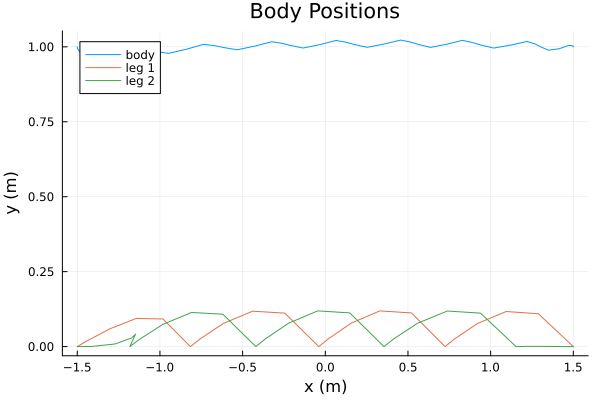

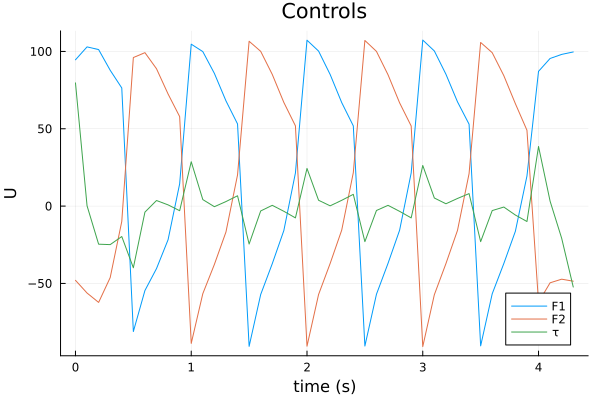

┌ Info: Listening on: 127.0.0.1:8701, thread id: 1
└ @ HTTP.Servers /home/burger/.julia/packages/HTTP/4AUPl/src/Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat /home/burger/.julia/packages/MeshCat/9QrxD/src/visualizer.jl:43


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Rfoot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x52, 0x66, 0x6f, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x52, 0x66, 0x6f, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "torso" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("body" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x6f, 0x72, 0x73, 0x6f, 0x2f, 0x62, 0x6f, 0x64, 0x79], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "Laxle" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x72, 0x73, 0x6f, 0x2f, 0x4c, 0x61, 0x78, 0x6c, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x72, 0x73, 0x6f, 0x2f, 0x4c, 0x61, 0x78, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "Lleg" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x4c, 0x6c, 0x65, 0x67, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "Rleg" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x52, 0x6c, 0x65, 0x67, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "Raxle" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6f, 0x72, 0x73, 0x6f, 0x2f, 0x52, 0x61, 0x78, 0x6c, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x72, 0x73, 0x6f, 0x2f, 0x52, 0x61, 0x78, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "Lfoot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x4c, 0x66, 0x6f, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x4c, 0x66, 0x6f, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8701, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8701), "127.0.0.1", "8701", nothing, Sockets.TCPServer(RawFD(23) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnab

Test Summary:                  | Pass  Total   Time
walker trajectory optimization |  272    272  31.8s


Test.DefaultTestSet("walker trajectory optimization", Any[], 272, false, false, true, 1.743224248280832e9, 1.743224280097566e9, false, "/home/burger/OCRL/HW4_S25/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl")

In [13]:
@testset "walker trajectory optimization" begin 
    
    # dynamics parameters 
    model = (g = 9.81, mb= 5.0, mf = 1.0, ℓ_min = 0.5, ℓ_max = 1.5)
    
    # problem size 
    nx = 12 
    nu = 3 
    tf = 4.4 
    dt = 0.1 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # initial and goal states 
    xic = [-1.5;1;-1.5;0;-1.5;0;0;0;0;0;0;0]
    xg =  [1.5;1;1.5;0;1.5;0;0;0;0;0;0;0]
    
    # index sets 
    M1 = vcat([ (i-1)*10      .+ (1:5)   for i = 1:5]...)
    M2 = vcat([((i-1)*10 + 5) .+ (1:5)   for i = 1:4]...)
    J1 = [5,15,25,35]
    J2 = [10,20,30,40]
    
    # reference trajectory 
    Xref, Uref = reference_trajectory(model, xic, xg, dt, N)
    
    # LQR cost function (tracking Xref, Uref)
    Q = diagm([1; 10; fill(1.0, 4); 1; 10; fill(1.0, 4)]);
    R = diagm(fill(1e-3,3))
    Qf = 1*Q;
    
    # create indexing utilities 
    idx = create_idx(nx,nu,N)
    
    # put everything useful in params 
    params = (
        model = model, 
        nx = nx,
        nu = nu,
        tf = tf, 
        dt = dt, 
        t_vec = t_vec,
        N = N, 
        M1 = M1, 
        M2 = M2,
        J1 = J1, 
        J2 = J2,
        xic = xic, 
        xg = xg,
        idx = idx,
        Q = Q, R = R, Qf = Qf,
        Xref = Xref, 
        Uref = Uref
    )
    
    # TODO: primal bounds (constraint 11)
    x_l = -Inf*ones(idx.nz) # update this 
    x_u =  Inf*ones(idx.nz) # update this 
    for i = 1:N
        x_l[idx.x[i][[2,4,6]]] .= 0.0
    end
    
    # TODO: inequality constraint bounds
    c_l = 0.5*ones(2*N) # update this 
    c_u = 1.5*ones(2*N) # update this 
    
    # TODO: initialize z0 with the reference Xref, Uref 
    z0 = zeros(idx.nz) # update this 
    for i = 1:N
        z0[idx.x[i]] = Xref[i]
    end
    for i = 1:(N-1)
        z0[idx.u[i]] = Uref[i]
    end

    # adding a little noise to the initial guess is a good idea 
    z0 = z0 + (1e-6)*randn(idx.nz)
    
    diff_type = :auto 
    
    Z = fmincon(walker_cost,walker_equality_constraint,walker_inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = true)
    
    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    # ------------plotting--------------
    Xm = hcat(X...)
    Um = hcat(U...)
    
    plot(Xm[1,:],Xm[2,:], label = "body")
    plot!(Xm[3,:],Xm[4,:], label = "leg 1")
    display(plot!(Xm[5,:],Xm[6,:], label = "leg 2",xlabel = "x (m)",
                  ylabel = "y (m)", title = "Body Positions"))

    display(plot(t_vec[1:end-1], Um',xlabel = "time (s)", ylabel = "U",
                 label = ["F1" "F2" "τ"], title = "Controls"))
    
    # ---------animation-------------
    vis = Visualizer()
    build_walker!(vis, model::NamedTuple)
    anim = mc.Animation(vis, fps=floor(Int,1/dt))
    for k = 1:N
        mc.atframe(anim, k) do
            update_walker_pose!(vis, model::NamedTuple, X[k])
        end
    end
    mc.setanimation!(vis, anim)
    display(render(vis))
    
    # --------testing---------------- 
    
    # initial and terminal states 
    @test norm(X[1] - xic,Inf) <= 1e-3 
    @test norm(X[end] - xg,Inf) <= 1e-3
    
    for x in X  
        
        # distance between bodies
        rb = x[1:2]
        rf1 = x[3:4]
        rf2 = x[5:6]
        @test (0.5 - 1e-3) <= norm(rb-rf1) <= (1.5 + 1e-3)
        @test (0.5 - 1e-3) <= norm(rb-rf2) <= (1.5 + 1e-3)
        
        # no two feet moving at once 
        v1 = x[9:10]
        v2 = x[11:12] 
        @test min(norm(v1,Inf),norm(v2,Inf)) <= 1e-3 
        
        # check everything above the surface 
        @test x[2] >= (0 - 1e-3)
        @test x[4] >= (0 - 1e-3)
        @test x[6] >= (0 - 1e-3)
        
    end
    
end